In [0]:
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
from keras.models import Model, load_model
from keras.models import load_model

# Регистрация сессии в keras
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [2]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/MRI_Second_Version'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Импорт датасета
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

img_width, img_height = 256, 256
batch_size = 4
latent_dim = 20
batch_shape = (batch_size, 256, 256, 1)
num_classes = 10
dropout_rate = 0.3
gamma = 1 

In [4]:
train_generator = datagen.flow_from_directory(
    path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode=None, 
    classes=['healthy_original'],
    batch_size=batch_size,
    subset = 'training')

targets_generator = datagen.flow_from_directory(
    path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode=None, 
    classes=['healthy_original'],
    batch_size=batch_size,
    subset = 'training')

Found 28 images belonging to 1 classes.
Found 28 images belonging to 1 classes.


In [5]:
val_generator = datagen.flow_from_directory(
    path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode=None, 
    classes=['healthy_original'],
    batch_size=batch_size,
    subset = 'validation')

val_targets_generator = datagen.flow_from_directory(
    path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode=None, 
    classes=['healthy_original'],
    batch_size=batch_size,
    subset = 'validation')

Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [0]:
train_batches_it = zip(train_generator, targets_generator)
test_batches_it  = zip(val_generator, val_targets_generator)

In [7]:
x_ = tf.placeholder(tf.float32, shape=(None, 256, 256, 1),  name='image')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim), name='z')

img = Input(tensor=x_)
z   = Input(tensor=z_)

In [8]:
# у меня получалось, что батч-нормализация очень сильно тормозит обучение на начальных этапах (подозреваю, что из-за того, что P и P_g почти не ра)
def apply_bn_relu_and_dropout(x, bn=False, relu=True, dropout=True):
    if bn:
        x = BatchNormalization(momentum=0.99, scale=False)(x)
    if relu:
        x = LeakyReLU()(x)
    if dropout:
        x = Dropout(dropout_rate)(x)
    return x

conv_size = 16
count_kernels = 64
kernel_shape = (4, 4)

with tf.variable_scope('encoder'):
  
    x = Conv2D(count_kernels, kernel_shape, activation='relu', padding='same')(img) 
    x = apply_bn_relu_and_dropout(x)
    x = MaxPool2D((2,2), padding = 'same')(x)
    
    x = Conv2D(count_kernels, kernel_shape, activation='relu', padding='same')(x) 
    x = apply_bn_relu_and_dropout(x)
    x = MaxPool2D((2,2), padding = 'same')(x)
    
    x = Conv2D(count_kernels, kernel_shape, activation='relu', padding='same')(x) 
    x = apply_bn_relu_and_dropout(x)
    x = MaxPool2D((2,2), padding = 'same')(x)
    
    x = Conv2D(count_kernels, kernel_shape, activation='relu', padding='same')(x)
    x = apply_bn_relu_and_dropout(x)
    x = MaxPool2D((2,2), padding = 'same')(x)

    x = Reshape((conv_size*conv_size*count_kernels,))(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
      z_mean, z_log_var = args
      batch = K.shape(z_mean)[0]
      dim = K.int_shape(z_mean)[1]
      epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.0)
      return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(img, [z_mean, z_log_var, l], name='Encoder')



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [9]:
with tf.variable_scope('decoder'):
    x = Dense(conv_size*conv_size*64, activation='relu')(z)
    x = Reshape((conv_size, conv_size, 64))(x)
    
    x = Conv2D(count_kernels,kernel_shape,activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(count_kernels,kernel_shape,activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(count_kernels,kernel_shape,activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(count_kernels,kernel_shape,activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(1,(8,8),activation='sigmoid', padding='same')(x)
decoder = Model(z, decoded, name='Decoder')


In [0]:
with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)
   
    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    # l-слой на котором будем сравнивать активации
    l = Conv2D(16, kernel_size=(3, 3), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model(img, [d, l], name='Discriminator')

In [0]:
z_mean, z_log_var, encoded_img = encoder(img)

decoded_img = decoder(encoded_img)
decoded_z   = decoder(z)

discr_img,     discr_l_img     = discrim(img)
discr_dec_img, discr_l_dec_img = discrim(decoded_img)
discr_dec_z,   discr_l_dec_z   = discrim(decoded_z)

cvae_model = Model(img, decoder(encoded_img), name='cvae')
cvae =  cvae_model(img)

In [12]:
L_prior = -0.5*tf.reduce_sum(1. + tf.clip_by_value(z_log_var, -2, 2) - tf.square(z_mean) - tf.exp(tf.clip_by_value(z_log_var, -2, 2)))/28/28

log_dis_img     = tf.log(discr_img + 1e-10)
log_dis_dec_z   = tf.log(1. - discr_dec_z + 1e-10)
log_dis_dec_img = tf.log(1. - discr_dec_img + 1e-10)

L_GAN = -1/4*tf.reduce_sum(log_dis_img + 2*log_dis_dec_z + log_dis_dec_img)/28/28

L_dis_llike = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.sigmoid(discr_l_img), logits=discr_l_dec_img))/28/28

# Лоссы энкодера, декодера, дискриминатора
L_enc = L_dis_llike + L_prior 
L_dec = gamma * L_dis_llike - L_GAN
L_dis = L_GAN


# Определение шагов оптимизатора
optimizer_enc = tf.train.RMSPropOptimizer(0.001)
optimizer_dec = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.001)

encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder")
discrim_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discrim")

step_enc = optimizer_enc.minimize(L_enc, var_list=encoder_vars)
step_dec = optimizer_dec.minimize(L_dec, var_list=decoder_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)


def step(image, zp):
    l_prior, dec_image, l_dis_llike, l_gan, _, _ = sess.run([L_prior, decoded_z, L_dis_llike, L_GAN, step_enc, step_dec],
                                                            feed_dict={z:zp, img:image, K.learning_phase():1})
    return l_prior, dec_image, l_dis_llike, l_gan

def step_d(image, zp):
    l_gan, _ = sess.run([L_GAN, step_dis], feed_dict={z:zp, img:image, K.learning_phase():1})
    return l_gan


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
digit_size = 256
def plot_brains(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


# Массивы, в которые будем сохранять результаты, для последующей визуализации
figs = [[] for x in range(num_classes)]
periods = []

save_periods = list(range(100)) + list(range(100, 1000, 10))

n = 15 # Картинка с 15x15 цифр
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
def draw_manifold(label, show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((digit_size * n, digit_size * n))
    input_lbl = np.zeros((1, 10))
    input_lbl[0, label] = 1
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_decoded = sess.run(decoded_z, feed_dict={z:z_sample, K.learning_phase():0})
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


# Рисование распределения z
def draw_z_distr(z_predicted):
    im = plt.scatter(z_predicted[:, 0], z_predicted[:, 1])
    im.axes.set_xlim(-5, 5)
    im.axes.set_ylim(-5, 5)
    plt.show()
    

def on_n_period(period):
    n_compare = 10

    clear_output() # Не захламляем output

    # Сравнение реальных и декодированных цифр
    b = next(test_batches_it)
    decoded = sess.run(cvae, feed_dict={img:b[0], K.learning_phase():0})
    plot_brains(b[0][:n_compare], decoded[:n_compare])

    # Рисование многообразия для рандомного y
    draw_lbl = np.random.randint(0, num_classes)    
    print(draw_lbl)
    #for label in range(num_classes):
        #figs[label].append(draw_manifold(label, show=label==draw_lbl))

    #xs = x_test[y_test == draw_lbl]
    #ys = y_test_cat[y_test == draw_lbl]
    #z_predicted = sess.run(z_mean, feed_dict={img:xs, lbl:ys, K.learning_phase():0})
    #draw_z_distr(z_predicted)
    
    #periods.append(period)

In [0]:
sess.run(tf.global_variables_initializer())

nb_step = 3 # Количество шагов во внутреннем цикле

batches_per_period = 3
for i in range(10000):
    print('.', end='')

    # Шаги обучения дискриминатора
    for j in range(nb_step):
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)
        l_g = step_d(b0, zp)
        if l_g < 1.0:
            break
        
    # Шаг обучения декодера и энкодера
    for j in range(nb_step):
        l_p, zx, l_d, l_g = step(b0, zp)
        if l_g > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)

    # Периодическая визуализация результата
    if not i % batches_per_period:
        period = i // batches_per_period
        if period in save_periods:
            on_n_period(period)
        print(i, l_p, l_d, l_g)
    if i % 400 == 0: 
      cvae_model.save('/content/drive/My Drive/MRI_Second_Version/vae_model.h5')

In [0]:
import os
import skimage
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops

In [0]:
test_data = []
for file_ in os.listdir('/content/drive/My Drive/MRI_Second_Version/tumor_original/'):
  test_data.append(plt.imread(os.path.join('/content/drive/My Drive/MRI_Second_Version/tumor_original/', file_))[:256,:256,:1].reshape(256,256,1))
x_test = np.asarray(test_data)

In [122]:
loaded_decoder = load_model('/content/drive/My Drive/MRI_Second_Version/vae_model.h5')
predicted_imgs = loaded_decoder.predict(x_test, batch_size=5)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


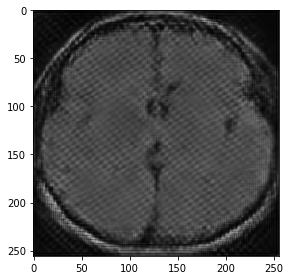

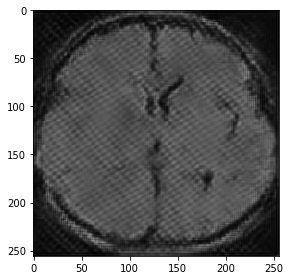

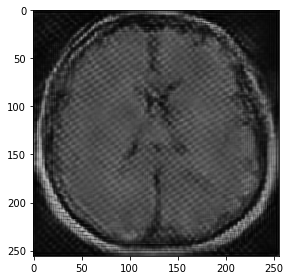

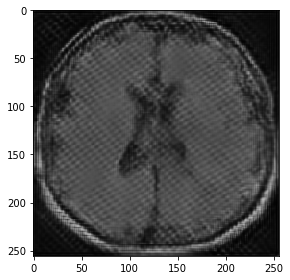

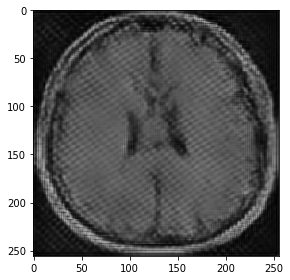

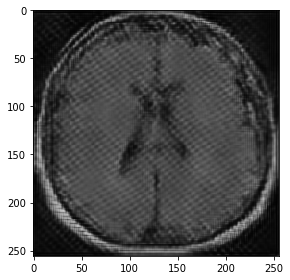

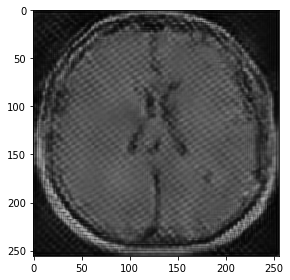

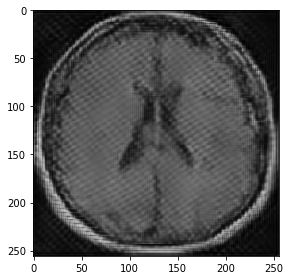

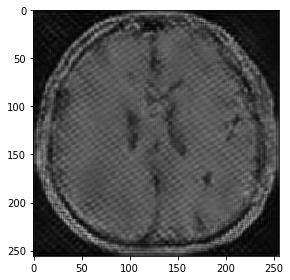

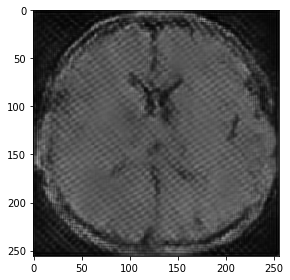

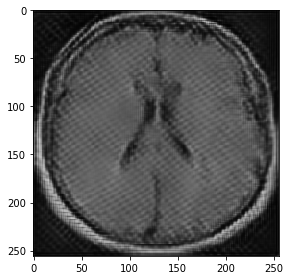

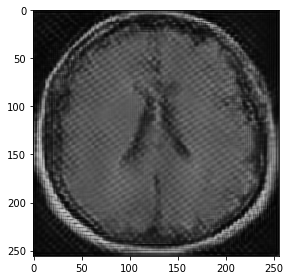

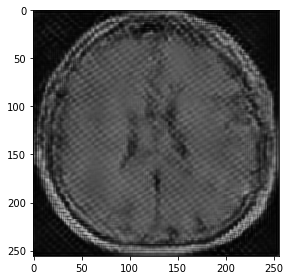

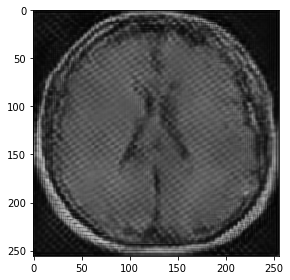

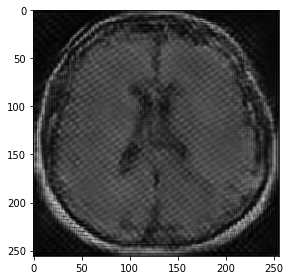

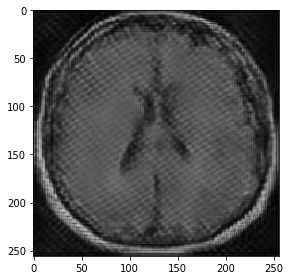

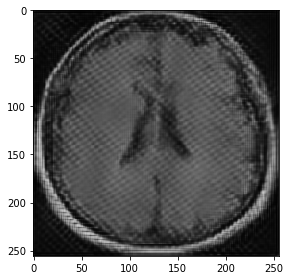

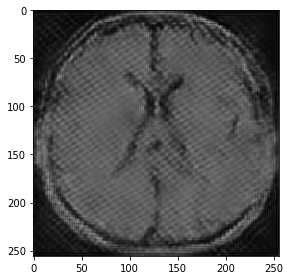

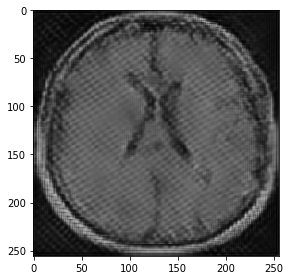

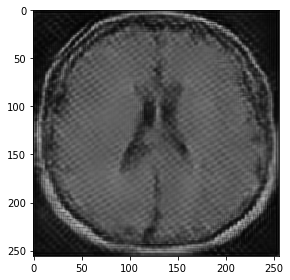

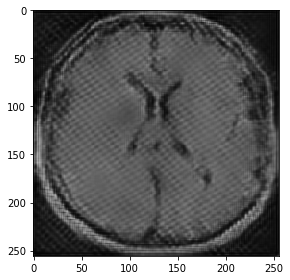

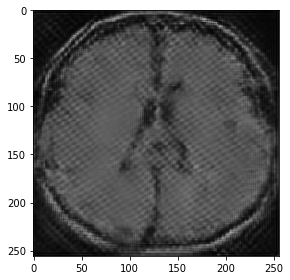

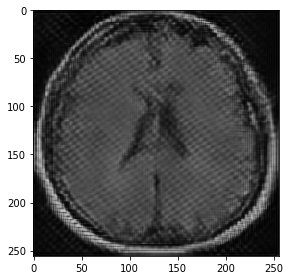

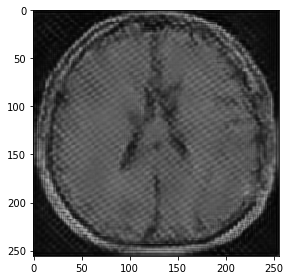

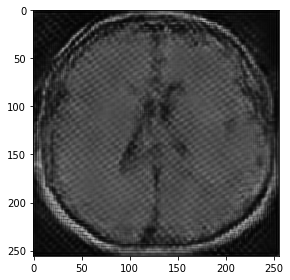

In [123]:
for x in range(25):
  skimage.io.imshow(predicted_imgs[x].reshape(256,256), cmap = 'gray')
  plt.show()

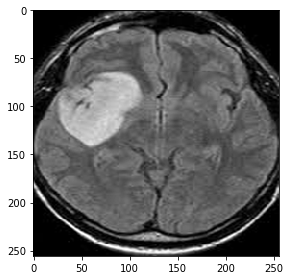

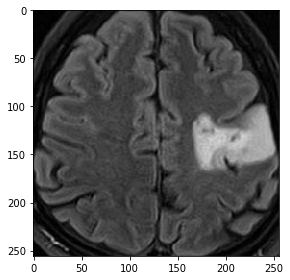

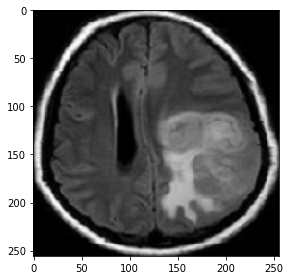

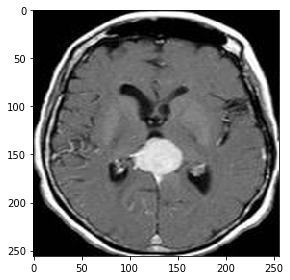

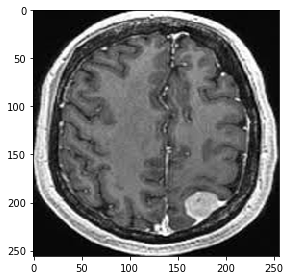

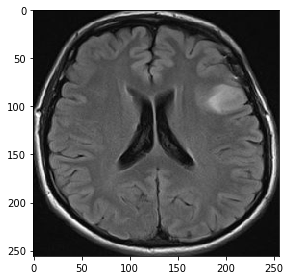

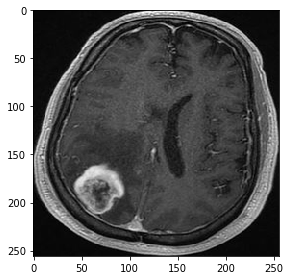

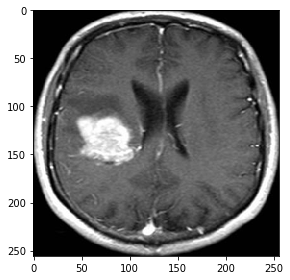

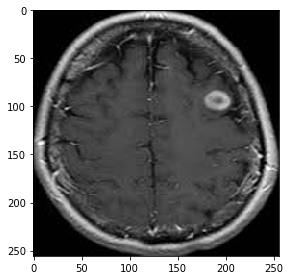

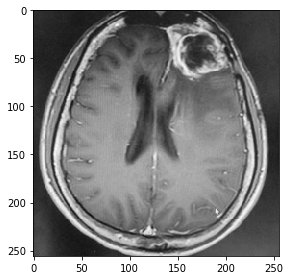

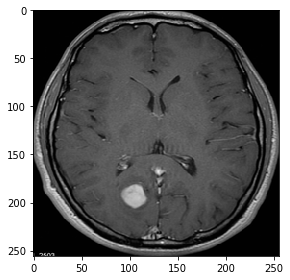

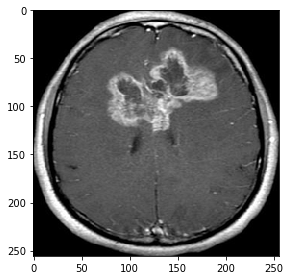

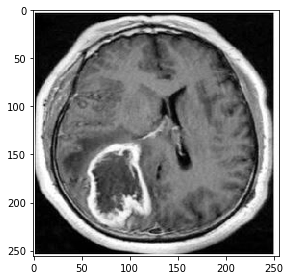

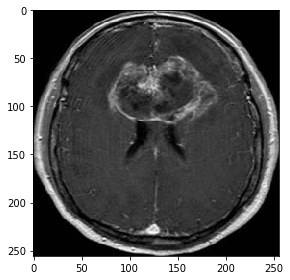

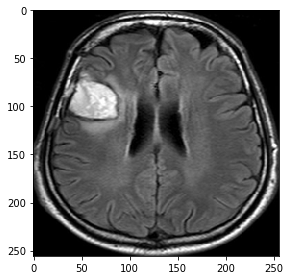

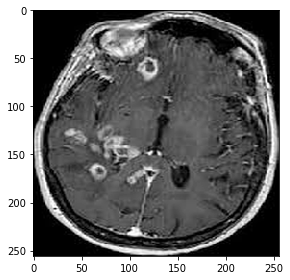

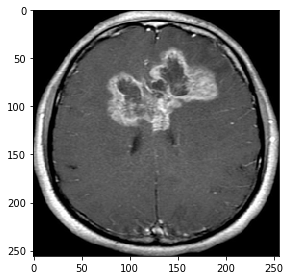

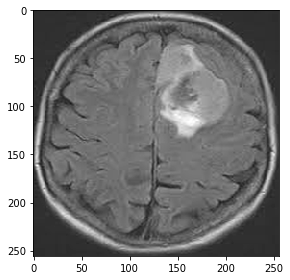

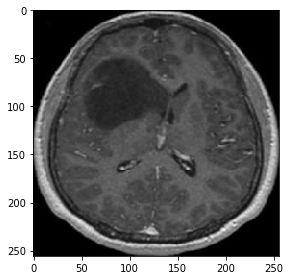

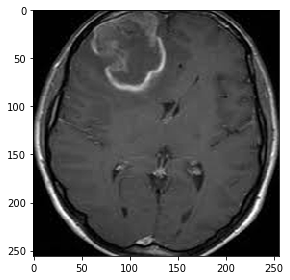

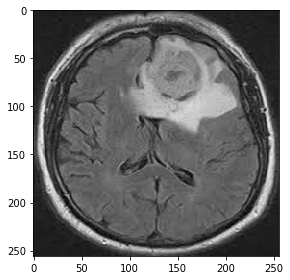

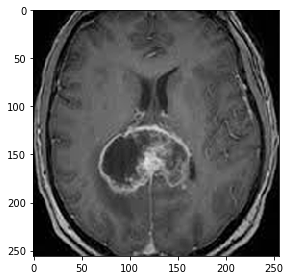

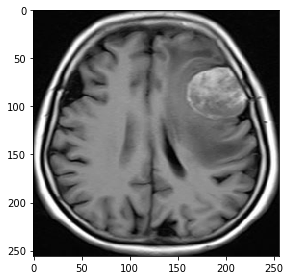

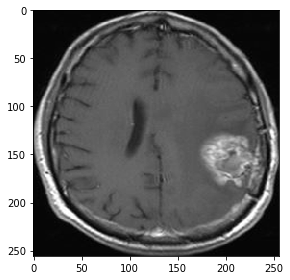

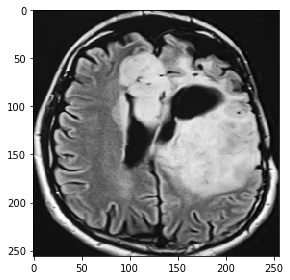

In [124]:
for i in range(25):
  skimage.io.imshow(x_test[i].reshape(256,256))
  plt.show()

In [0]:
th_images = []
th_images_striped = []
for x in range(25):
  image = x_test[x].reshape(256,256) - predicted_imgs[x].reshape(256,256)
  image_th = 0.3 < image
  th_images.append(image_th)
  
for x in range(25): 
  image = x_test[x].reshape(256,256) - predicted_imgs[x].reshape(256,256)
  image_th = 0.3 < image
  label_image = label(image_th)
  for region in regionprops(label_image):
    if(region.extent < 0.3):
      for coord in region.coords:
        image_th[coord[0]][coord[1]] = False
  th_images_striped.append(image_th)
  

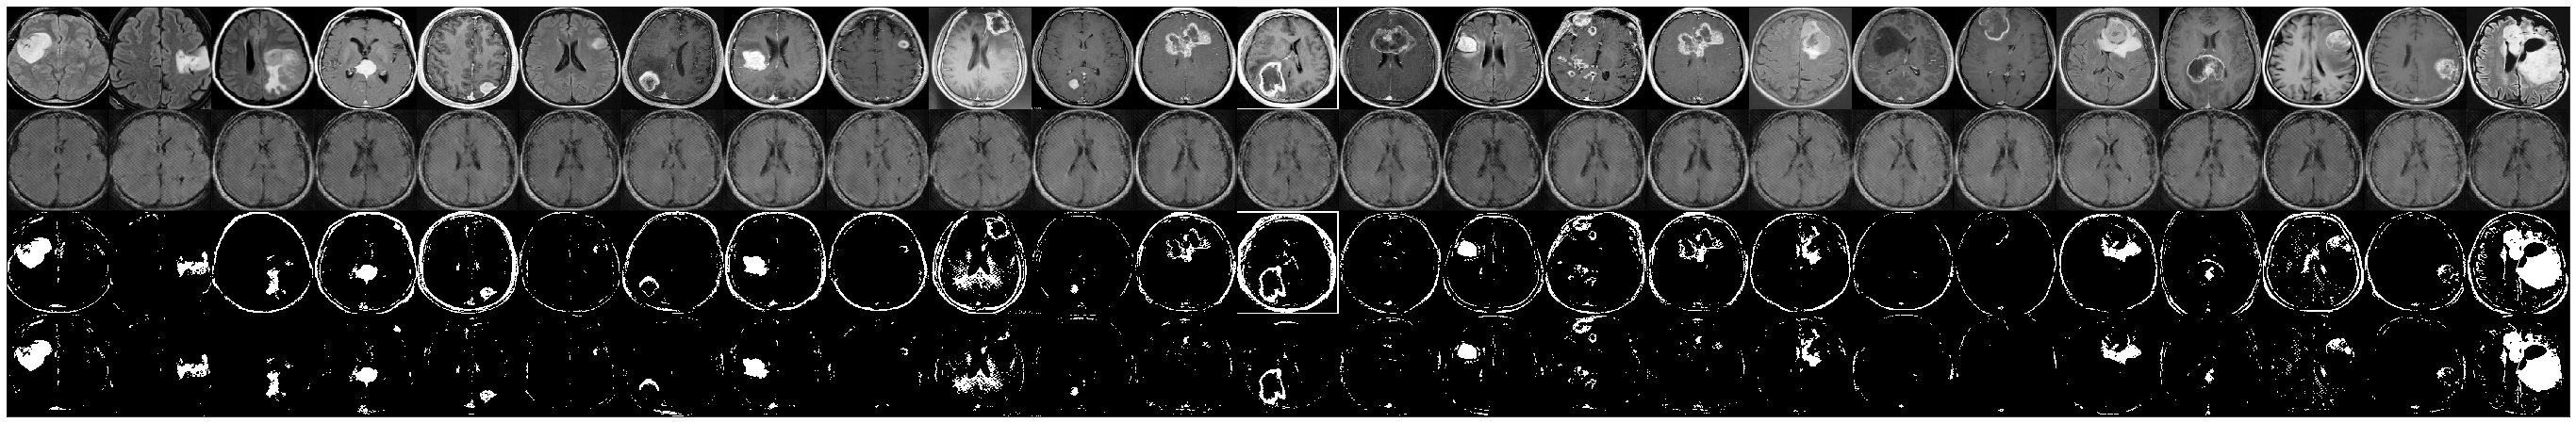

In [149]:
plot_brains(x_test, predicted_imgs, np.asarray(th_images), np.asarray(th_images_striped))